In [1]:
#importing the required packages
import numpy as np
import pickle
from matplotlib import pyplot as plt
from skimage.feature import hog

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
%cd /content/drive/MyDrive/ColabNotebooks/nn_numpy

/content/drive/MyDrive/ColabNotebooks/nn_numpy


In [18]:
from nn.activation import *
from nn.linear import *
from nn.loss import *
from nn.module import *
from nn.batchnorm import *
from nn.dropout import *

## Image Classification

### Data Preparation and Other Utilities

We use the `CIFAR-10` dataset for our task. `CIFAR-10` dataset consists of $10$ classes with $5000$ training set and $1000$ test set 32 x 32 RGB images for each class. We perform two tasks using our Neural Network: 

1. Two class classification (`Airplane`(0) / `Ship`(1)) 
2. Five class classification (`Cat`(0) / `Deer`(1) / `Dog`(2) / `Frog`(3) / `Horse`(4))

We extract the complete dataset and convert the images to 32 x 32 grayscale images with pixel intensity values between $0$ and $1$.  

In [5]:
#function which takes a pickle file as input and outputs the file contents in form of dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic

# basePath = "./CIFAR10/data_batch_"
basePath = "/content/drive/MyDrive/ColabNotebooks/introML/\
PA2/cores/datasets/cifar-10-batches-py/data_batch_"

#reading and storing the training set
trainImages = np.empty((0,3072), dtype=np.float32)
trainLabels = list()
for i in range(1,6):
    trainset = unpickle(basePath + str(i))
    trainImages = np.vstack((trainImages, trainset[b"data"].astype(np.float32)))
    trainLabels.extend(trainset[b"labels"])
trainLabels = np.array(trainLabels)

#reading and storing the test set
# testset = unpickle("./CIFAR10/test_batch")
testset = unpickle("/content/drive/MyDrive/ColabNotebooks/introML/\
PA2/cores/datasets/cifar-10-batches-py/test_batch")
testImages = testset[b"data"].astype(np.float32)
testLabels = np.array(testset[b"labels"])

#reading the meta file for the label names
# labelNames = unpickle("./CIFAR10/batches.meta")[b"label_names"]
labelNames = unpickle("/content/drive/MyDrive/ColabNotebooks/introML/\
PA2/cores/datasets/cifar-10-batches-py/batches.meta")[b"label_names"]

In [6]:
#converting the RGB images to grayscale, scaling them to 0-1 and reshaping them to 32x32
trainImages = (0.299*trainImages[:,:1024] + 0.587*trainImages[:,1024:2048] + 0.114*trainImages[:,2048:])/255.0
trainImages = trainImages.reshape((trainImages.shape[0], 32, 32))

testImages = (0.299*testImages[:,:1024] + 0.587*testImages[:,1024:2048] + 0.114*testImages[:,2048:])/255.0
testImages = testImages.reshape((testImages.shape[0], 32, 32))

**Training Steps**

For one epoch:
1. Divide the training data set into batches depending upon the batch size.
2. For each batch, do a forward pass of the model and obtain the model outputs.
3. Given the model outputs and the target labels for the batch, compute the loss value.
4. Perform a backward pass on the loss function and the model for obtaining the values of loss gradient with respect to the model parameters.
5. Perform one step of Gradient Descent update to update the model parameters.
6. Repeat from 2. for all batches.

`train` - Trains the model for one epoch over the training set as described above. After training the model for one epoch, the function computes the per sample average training set loss value and accuracy.

`validation` - The function computes the per sample average validation set loss value and accuracy.

`test` - The function computes the per sample average test set loss value and accuracy.

In [7]:
#function for training the model for one epoch
def train(model, X, Y, loss_function):
    
    #calculate the number of batches given the batch size
    numBatches = int(np.ceil(len(X)/BATCH_SIZE))
    for batch in range(numBatches):
        
        #extracting the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
        
        #computing the model output and loss
        outputs = model.forward(x)
        loss = loss_function.forward(outputs, y)
        
        #backpropagation step to calculate the gradients
        lossGradients = loss_function.backward()
        model.backward(lossGradients)
        
        #update the parameters
        model.step()

        
    #getting the training set loss and training set accuracy after one epoch of training
    trainingLoss = 0
    trainingAccuracy = 0
    for batch in range(numBatches):
        
        #extract the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
            
        #computing the model outputs and loss
        outputs = model.forward(x) 
        loss = loss_function.forward(outputs, y) 
        
        #accumulating the per batch loss and accuracy
        trainingLoss = trainingLoss + loss
        trainingAccuracy = trainingAccuracy + (np.count_nonzero(np.equal(np.argmax(outputs, axis=1), y)))/len(outputs)
    
    #computing the per sample training set loss and accuracy
    trainingLoss = trainingLoss/numBatches
    trainingAccuracy = trainingAccuracy/numBatches
    return trainingLoss, trainingAccuracy



#function to calculate the validation set loss and accuracy
def validate(model, X, Y, loss_function):
    
    #calculate the number of batches given the batch size
    numBatches = int(np.ceil(len(X)/BATCH_SIZE))
    
    validationLoss = 0
    validationAccuracy = 0
    for batch in range(numBatches):
        
        #extract the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
            
        #computing the model outputs and loss
        outputs = model.forward(x) 
        loss = loss_function.forward(outputs, y) 
        
        #accumulating the per batch loss and accuracy
        validationLoss = validationLoss + loss
        validationAccuracy = validationAccuracy + (np.count_nonzero(np.equal(np.argmax(outputs, axis=1), y)))/len(outputs)
    
    #getting the per sample loss and accuracy
    validationLoss = validationLoss/numBatches
    validationAccuracy = validationAccuracy/numBatches
    return validationLoss, validationAccuracy



#function to calculate the test set loss and accuracy
def test(model, X, Y, loss_function):
    
    #calculating the number of batches given the batch size
    numBatches = int(np.ceil(len(X)/BATCH_SIZE))
    testLoss = 0
    testAccuracy = 0
    for batch in range(numBatches):
        
        #extract the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
            
        #computing the model outputs and loss
        outputs = model.forward(x) 
        loss = loss_function.forward(outputs, y) 
        
        #accumulating the per batch loss and accuracy
        testLoss = testLoss + loss
        testAccuracy = testAccuracy + (np.count_nonzero(np.equal(np.argmax(outputs, axis=1), y)))/len(outputs)
    
    #obtaining the per sample loss and accuracy
    testLoss = testLoss/numBatches
    testAccuracy = testAccuracy/numBatches
    return testLoss, testAccuracy

### Two classes

We filter the data set to include only the `Airplane` and the `Ship` classes. We assign label $0$ to the `Airplane` class and label $1$ to the `Ship` class. We use the Histogram of Oriented Gradients (HOG) Descriptors as feature vectors. We extract $288$ HOG features for each image. We normalize the data using `mean` and `std` and split the training set into training ($80\%$) and validation ($20\%$) sets. 


The Neural Network architecture used consists of $1$ input layer, $3$ hidden layers each with `ReLU` activation and $1$ output layer with `Softmax` activation so that the model output is a probability distribution. We use the `Cross Entropy` Loss function to train the network.

The hyperparameter values used are:
- Batch Size = $1024$
- Epochs = $175$
- Learning Rate = $0.01$

In [ ]:
#filtering the data set to include only the two classes
classes = [b'airplane', b'ship']
class0 = labelNames.index(classes[0])
class1 = labelNames.index(classes[1])

trainX = trainImages[(trainLabels == class0) | (trainLabels == class1)]
trainY = trainLabels[(trainLabels == class0) | (trainLabels == class1)]
trainY[trainY == class0] = 0
trainY[trainY == class1] = 1

testX = testImages[(testLabels == class0) | (testLabels == class1)]
testY = testLabels[(testLabels == class0) | (testLabels == class1)]
testY[testY == class0] = 0
testY[testY == class1] = 1


#extracting the HOG features
trainX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in trainX])
testX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in testX])


#normalizing the data
mean = np.mean(trainX, axis=0, keepdims=True)
std = np.std(trainX, axis=0, keepdims=True)
trainX = (trainX - mean)/std
testX = (testX - mean)/std


#values of hyperparameters
SEED = 100
VAL_SPLIT = 0.2
BATCH_SIZE = 1024
NUM_EPOCHS = 175
LEARNING_RATE = 0.01


#splitting the training set into training and validation sets
np.random.seed(SEED)
indices = np.arange(len(trainX))
np.random.shuffle(indices)
valX = trainX[indices[:int(VAL_SPLIT*len(indices))]]
valY = trainY[indices[:int(VAL_SPLIT*len(indices))]]
trainX = trainX[indices[int(VAL_SPLIT*len(indices)):]]
trainY = trainY[indices[int(VAL_SPLIT*len(indices)):]]



Number of Parameters in Model = 219170

Training the model .... 

Epoch: 1, Tr.Loss: 0.744878, Val.Loss: 0.743057, Tr.Acc: 0.503, Val.Acc: 0.494
Epoch: 2, Tr.Loss: 0.725365, Val.Loss: 0.731032, Tr.Acc: 0.514, Val.Acc: 0.508
Epoch: 3, Tr.Loss: 0.715398, Val.Loss: 0.725031, Tr.Acc: 0.525, Val.Acc: 0.504
Epoch: 4, Tr.Loss: 0.708331, Val.Loss: 0.712323, Tr.Acc: 0.541, Val.Acc: 0.542
Epoch: 5, Tr.Loss: 0.703055, Val.Loss: 0.709938, Tr.Acc: 0.547, Val.Acc: 0.532
Epoch: 6, Tr.Loss: 0.699328, Val.Loss: 0.712497, Tr.Acc: 0.543, Val.Acc: 0.511
Epoch: 7, Tr.Loss: 0.692381, Val.Loss: 0.693237, Tr.Acc: 0.554, Val.Acc: 0.542
Epoch: 8, Tr.Loss: 0.688377, Val.Loss: 0.689332, Tr.Acc: 0.556, Val.Acc: 0.559
Epoch: 9, Tr.Loss: 0.686551, Val.Loss: 0.684510, Tr.Acc: 0.564, Val.Acc: 0.561
Epoch: 10, Tr.Loss: 0.685820, Val.Loss: 0.676594, Tr.Acc: 0.570, Val.Acc: 0.565
Epoch: 11, Tr.Loss: 0.673832, Val.Loss: 0.685540, Tr.Acc: 0.586, Val.Acc: 0.564
Epoch: 12, Tr.Loss: 0.674245, Val.Loss: 0.659542, Tr.Acc: 0.58

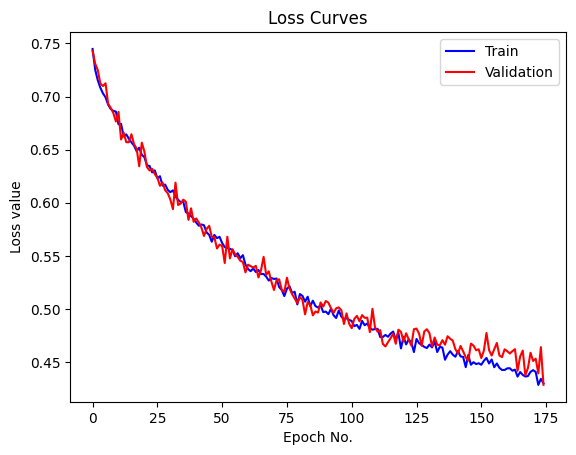

In [21]:
#Model architecture
class Net(Module):
    def __init__(self, use_batchnorm, dropout):
        super(Net, self).__init__()
        self.fc1 = Linear(288,512,LEARNING_RATE)
        self.afunc1 = ReLU()
        self.fc2 = Linear(512,128,LEARNING_RATE)
        self.afunc2 = ReLU()
        self.fc3 = Linear(128,32,LEARNING_RATE)
        self.afunc3 = ReLU()
        self.fc4 = Linear(32,2,LEARNING_RATE)
        self.afunc4 = Softmax()

        self.use_batchnorm = use_batchnorm

        if use_batchnorm is True:
          self.bn1 = Batchnorm(512, LEARNING_RATE)
          self.bn2 = Batchnorm(128, LEARNING_RATE)
          self.bn3 = Batchnorm(32, LEARNING_RATE)

        self.do1 = Dropout(dropout)
        self.do2 = Dropout(dropout)
        self.do3 = Dropout(dropout)
        return
    
    def forward(self, x):
        x = self.fc1.forward(x)
        if self.use_batchnorm:
          x = self.bn1.forward(x)
        x = self.afunc1.forward(x)
        x = self.do1.forward(x)
        
        x = self.fc2.forward(x)
        if self.use_batchnorm:
          x = self.bn2.forward(x)
        x = self.afunc2.forward(x)
        x = self.do2.forward(x)

        x = self.fc3.forward(x)
        if self.use_batchnorm:
          x = self.bn3.forward(x)
        x = self.afunc3.forward(x)
        x = self.do3.forward(x)

        x = self.fc4.forward(x)
        x = self.afunc4.forward(x)
        return x
    
    def backward(self, gradients):
        gradients = self.afunc4.backward(gradients)
        gradients = self.fc4.backward(gradients)

        gradients = self.do3.backward(gradients)
        gradients = self.afunc3.backward(gradients)
        if self.use_batchnorm:
          gradients = self.bn3.backward(gradients)
        gradients = self.fc3.backward(gradients)

        gradients = self.do2.backward(gradients)
        gradients = self.afunc2.backward(gradients)
        if self.use_batchnorm:
          gradients = self.bn2.backward(gradients)
        gradients = self.fc2.backward(gradients)

        gradients = self.do1.backward(gradients)
        gradients = self.afunc1.backward(gradients)
        if self.use_batchnorm:
          gradients = self.bn1.backward(gradients)        
        gradients = self.fc1.backward(gradients)
        return
    
    def step(self):
        self.fc1.step()
        self.fc2.step()
        self.fc3.step()
        self.fc4.step()

        if self.use_batchnorm:
          self.bn1.step()
          self.bn2.step()
          self.bn3.step()
        return
    
    def num_params(self):
        numParams = 0
        numParams = numParams + self.fc1.num_params()
        numParams = numParams + self.fc2.num_params()
        numParams = numParams + self.fc3.num_params()
        numParams = numParams + self.fc4.num_params()

        if self.use_batchnorm:
          numParams += self.bn1.num_params()
          numParams += self.bn2.num_params()
          numParams += self.bn3.num_params()
        return numParams
    
    
#loss function and model initialization
loss_function = CrossEntropyLoss()
# model = Net(False, 1)
model = Net(True, 0.5)
print("\nNumber of Parameters in Model = " + str(model.num_params()))

print('\nTraining the model .... \n')
trainingLossCurve = []
validationLossCurve = []
for epoch in range(1, NUM_EPOCHS+1):
    
    #shuffle the dataset so the composition of batches differs every epoch
    indices = np.arange(len(trainX))
    np.random.shuffle(indices)
    trainX = trainX[indices]
    trainY = trainY[indices]
    
    #train for one epoch and obtain the training set loss and accuracy
    trainingLoss, trainingAccuracy = train(model, trainX, trainY, loss_function)
    trainingLossCurve.append(trainingLoss)
    
    #obtain the validation set loss and accuracy
    validationLoss, validationAccuracy = validate(model, valX, valY, loss_function)
    validationLossCurve.append(validationLoss)
    print('Epoch: %d, Tr.Loss: %.6f, Val.Loss: %.6f, Tr.Acc: %.3f, Val.Acc: %.3f' 
          %(epoch, trainingLoss, validationLoss, trainingAccuracy, validationAccuracy))


    
print('\nTesting the model .... \n')
#obtain the test set loss and accuracy
testLoss, testAccuracy = test(model, testX, testY, loss_function)
print('Test Loss: %.6f, Test Accuracy: %.3f' %(testLoss, testAccuracy))


#plot the training loss and validation loss curves
plt.figure()
plt.title('Loss Curves')
plt.xlabel('Epoch No.')
plt.ylabel('Loss value')
plt.plot(trainingLossCurve, 'b', label='Train')
plt.plot(validationLossCurve, 'r', label='Validation')
plt.legend()
plt.show()

### Five classes

We filter the data set to include the `Cat`, `Deer`, `Dog`, `Frog` and `Horse` classes. We assign labels from $0$ to $4$ in the given order to the classes. We use the Histogram of Oriented Gradients (HOG) Descriptors as feature vectors. We extract $288$ HOG features for each image. We normalize the data using `mean` and `std` and split the training set into training ($80\%$) and validation ($20\%$) sets. 


The Neural Network architecture used consists of $1$ input layer, $4$ hidden layers each with `ReLU` activation and $1$ output layer with `Softmax` activation so that the model output is a probability distribution. We use the `Cross Entropy` Loss function to train the network.

The hyperparameter values used are:
- Batch Size = $512$
- Epochs = $250$
- Learning Rate = $0.005$

In [ ]:
#filtering the data to include only the five classes
classes = [b'cat', b'deer', b'dog', b'frog', b'horse']
class0 = labelNames.index(classes[0])
class1 = labelNames.index(classes[1])
class2 = labelNames.index(classes[2])
class3 = labelNames.index(classes[3])
class4 = labelNames.index(classes[4])

trainX = trainImages[(trainLabels == class0) | (trainLabels == class1) | (trainLabels == class2) | 
                     (trainLabels == class3) | (trainLabels == class4)]
trainY = trainLabels[(trainLabels == class0) | (trainLabels == class1) | (trainLabels == class2) | 
                     (trainLabels == class3) | (trainLabels == class4)]
trainY[trainY == class0] = 0
trainY[trainY == class1] = 1
trainY[trainY == class2] = 2
trainY[trainY == class3] = 3
trainY[trainY == class4] = 4

testX = testImages[(testLabels == class0) | (testLabels == class1) | (testLabels == class2) | 
                   (testLabels == class3) | (testLabels == class4)]
testY = testLabels[(testLabels == class0) | (testLabels == class1) | (testLabels == class2) | 
                   (testLabels == class3) | (testLabels == class4)]
testY[testY == class0] = 0
testY[testY == class1] = 1
testY[testY == class2] = 2
testY[testY == class3] = 3
testY[testY == class4] = 4


#extracting the HOG features
trainX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in trainX])
testX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in testX])


#normalizing the data set
mean = np.mean(trainX, axis=0, keepdims=True)
std = np.std(trainX, axis=0, keepdims=True)
trainX = (trainX - mean)/std
testX = (testX - mean)/std


#values of the hyperparameters
SEED = 100
VAL_SPLIT = 0.2
BATCH_SIZE = 512
NUM_EPOCHS = 250
LEARNING_RATE = 0.005


#splitting the training set into training and validation set
np.random.seed(SEED)
indices = np.arange(len(trainX))
np.random.shuffle(indices)
valX = trainX[indices[:int(VAL_SPLIT*len(indices))]]
valY = trainY[indices[:int(VAL_SPLIT*len(indices))]]
trainX = trainX[indices[int(VAL_SPLIT*len(indices)):]]
trainY = trainY[indices[int(VAL_SPLIT*len(indices)):]]


#Model architecture
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = Linear(288,512,LEARNING_RATE)
        self.afunc1 = ReLU()
        self.fc2 = Linear(512,256,LEARNING_RATE)
        self.afunc2 = ReLU()
        self.fc3 = Linear(256,64,LEARNING_RATE)
        self.afunc3 = ReLU()
        self.fc4 = Linear(64,16,LEARNING_RATE)
        self.afunc4 = ReLU()
        self.fc5 = Linear(16,5,LEARNING_RATE)
        self.afunc5 = Softmax()
        return
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.afunc1.forward(x)
        x = self.fc2.forward(x)
        x = self.afunc2.forward(x)
        x = self.fc3.forward(x)
        x = self.afunc3.forward(x)
        x = self.fc4.forward(x)
        x = self.afunc4.forward(x)
        x = self.fc5.forward(x)
        x = self.afunc5.forward(x)
        return x
    
    def backward(self, gradients):
        gradients = self.afunc5.backward(gradients)
        gradients = self.fc5.backward(gradients)
        gradients = self.afunc4.backward(gradients)
        gradients = self.fc4.backward(gradients)
        gradients = self.afunc3.backward(gradients)
        gradients = self.fc3.backward(gradients)
        gradients = self.afunc2.backward(gradients)
        gradients = self.fc2.backward(gradients)
        gradients = self.afunc1.backward(gradients)
        gradients = self.fc1.backward(gradients)
        return
    
    def step(self):
        self.fc1.step()
        self.fc2.step()
        self.fc3.step()
        self.fc4.step()
        self.fc5.step()
        return
    
    def num_params(self):
        numParams = 0
        numParams = numParams + self.fc1.num_params()
        numParams = numParams + self.fc2.num_params()
        numParams = numParams + self.fc3.num_params()
        numParams = numParams + self.fc4.num_params()
        numParams = numParams + self.fc5.num_params()
        return numParams
    
    
#loss function and model initialization
loss_function = CrossEntropyLoss()
model = Net()
print("\nNumber of Parameters in Model = " + str(model.num_params()))


print('\nTraining the model .... \n')
trainingLossCurve = []
validationLossCurve = []
for epoch in range(1, NUM_EPOCHS+1):
    
    #shuffle the dataset so that the composition of batches differs every epoch
    indices = np.arange(len(trainX))
    np.random.shuffle(indices)
    trainX = trainX[indices]
    trainY = trainY[indices]
    
    #train the model for one epoch and obtain the training set loss and accuracy
    trainingLoss, trainingAccuracy = train(model, trainX, trainY, loss_function)
    trainingLossCurve.append(trainingLoss)
    
    #obtain the validation set loss and accuracy
    validationLoss, validationAccuracy = validate(model, valX, valY, loss_function)
    validationLossCurve.append(validationLoss)
    print('Epoch: %d, Tr.Loss: %.6f, Val.Loss: %.6f, Tr.Acc: %.3f, Val.Acc: %.3f' 
          %(epoch, trainingLoss, validationLoss, trainingAccuracy, validationAccuracy))


#obtain the test set loss and accuracy    
print('\nTesting the model .... \n')
testLoss, testAccuracy = test(model, testX, testY, loss_function)
print('Test Loss: %.6f, Test Accuracy: %.3f' %(testLoss, testAccuracy))


#plotting the training and validation loss curves
plt.figure()
plt.title('Loss Curves')
plt.xlabel('Epoch No.')
plt.ylabel('Loss value')
plt.plot(trainingLossCurve, 'b', label='Train')
plt.plot(validationLossCurve, 'r', label='Validation')
plt.legend()
plt.show()